## Resources

https://drive.google.com/drive/folders/1VD8J-zYix3mD31jbIBhqK2fke-

https://github.com/nlpcuom/WEIntrinsicEvaluation

## Obectives

1. Experiment CBOW and skip gram model with LOgistic regression, SVC, Random forest with df_A,df_B,df_C
2. Train own wor2vec
3. Fine tuning word2vec 

## Observations

1. Word embedding CBOW and skip gram both perform worser than traditiona feature extraction methods
2. It can be observed CBOW perform better than skipgram
3. SVC perform worser and gave very low values
4. Not only recall is low overall precison is low
5. There is no punctuation,number, english words similarity in common crawl word2vec so all punctuation,numbers,noise need to be remove

## Posible reasons
1. Since we are averaging 300 dimentional vectors we are not getting maximum outcome of word2vec
2. Word2vec cannot handle OOV which is very common in this hate speech detection
3. Common Crawl and distribution dataset is different 

## Further investigations and solutions
1. Training our own word2vec using informal sinhala text documents/ combining all four datasets?
2. Fine tuning word2vec
4. Possible solutions to handle OOV instead of setting random value
5. Investigate affect of stemming

## Word2vec model with logistic regression

size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW

## Load modules and datasets

In [39]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
from neptunecontrib.api import log_table
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
             

Project(codekcg23/Research-Experiments)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve,roc_auc_score,confusion_matrix,recall_score
from sklearn.pipeline import Pipeline
import re
import gensim

# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills

In [2]:
# load datasets
path = '../Datasets/processed/no_preprocessing/'
df_A = pd.read_csv(path+'df_A.csv')    
df_B = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle 
df_A_B = pd.read_csv(path+'df_A_B.csv') 


In [33]:
# load datasets
path = '../Datasets/processed/preprocessing/'
df_A_p = pd.read_csv(path+'df_A.csv')    
df_B_p = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle 
df_A_B_p = pd.read_csv(path+'df_A_B.csv') 


## Load word2vec models and test

### skip gram

In [3]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/word2vec/word2vec_300.w2v")
path = "../Embedding_models/cbow_300.w2v"



In [17]:
print(model.wv.most_similar('ලැජ්ජයි'))
print(model.wv.most_similar('මෑරෙන්න'))
print(model.wv.most_similar('යකො'))
print(model.wv.most_similar('හොරා'))
print(model.wv.most_similar('බල්ලා'))
print(model.wv.most_similar('තම්බි'))
print(model.wv.most_similar('හුත්ති'))
print(model_cbow.wv.most_similar('මුස්ලිම්'))
print(model.wv.most_similar('මුස්ලිම'))
print(model_cbow.wv.most_similar('සිංහල'))
print(model_cbow.wv.most_similar('වෛරය'))
print(model_cbow.wv.most_similar(['අම්මා']))
print(model_cbow.wv.most_similar(['ගෙදර']))

[('ෂිකේ.', 0.624288022518158), ('දැක්කහමමචං', 0.606025218963623), ('අසරනට', 0.6009397506713867), ('ගානවාවල', 0.5993783473968506), ('තිලකයියේ', 0.5935572385787964), ('නාගෙනදඟලන්න', 0.5622760057449341), ('හිත්න්නත්', 0.5605373978614807), ('ආණ්දුව', 0.5562554597854614), ('්ගමයාවිලි', 0.5535441637039185), ('දැක්කම\tපිනා', 0.5499239563941956)]
[('හෑබෑමයි', 0.6853367686271667), ('වෙන්නජීවත්', 0.615235447883606), ('වෙලාවකඉපදුනේ', 0.5789225101470947), ('හෙටවෙයිද', 0.5657752752304077), ('ලෑස්තිවෙයල්ල', 0.5579881072044373), ('\u200dබොම්බ', 0.5476895570755005), ('දෙයක්අන්ඩුවට', 0.5422118306159973), ('දෑක්කනම්', 0.5235146880149841), ('ෆොන්නඩෝටත්', 0.5233187675476074), ('වෑස්සටවත්', 0.5230247974395752)]
[('යකෝ', 0.6215049624443054), ('පුරුන්ග', 0.5947710871696472), ('හොයපි', 0.5878672003746033), ('වේසික', 0.5774468779563904), ('සඳරුවණ්', 0.5767057538032532), ('බන්', 0.5762976408004761), ('පෑන්චියො', 0.5738309621810913), ('මේරටෙ', 0.5726816058158875), ('තිරිසනාතොපෙ', 0.572677731513977), ('දුශ්ඨයෙක්ට

In [18]:
words_skipgram = list(model.wv.vectors)
print(len(words_skipgram))
print(model)

2137729


array([ 5.08443177e-01,  1.32564828e-01,  4.31842469e-02,  2.70150937e-02,
        1.51776105e-01, -2.16437578e-01,  3.10770035e-01, -6.40931353e-02,
       -1.85485452e-01, -8.43153670e-02,  8.40954185e-02,  4.69647944e-01,
        1.33402392e-01, -1.82146963e-03, -3.78949083e-02, -7.48745650e-02,
       -1.57882899e-01, -2.19975427e-01,  1.52760357e-01,  5.83701581e-02,
        1.58777058e-01, -5.03952499e-04, -3.73210385e-03,  3.13863993e-01,
       -3.70983541e-01,  1.58641458e-01,  1.82556078e-01, -1.49595827e-01,
        2.52814651e-01,  2.35548720e-01,  3.51897925e-02,  3.37331835e-03,
        5.44968136e-02, -1.29849628e-01, -2.08024591e-01, -3.58635604e-01,
       -9.72065553e-02, -4.44417819e-03, -5.19370213e-02, -1.21049806e-01,
       -5.45403399e-02,  1.99535862e-01,  6.36142343e-02, -6.99187815e-02,
       -3.42354774e-01,  1.07773028e-01, -6.28971159e-02,  2.28678752e-02,
       -1.49989398e-02, -5.12099713e-02,  1.66838225e-02,  2.16112152e-01,
       -3.54278833e-01,  

### CBOW

In [5]:
from gensim.models import word2vec
model_cbow = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/CBOW-word2vec/cbow_300.w2v")
path = "../Embedding_models/cbow_300.w2v"

In [6]:
print(model_cbow.wv.most_similar('ලැජ්ජයි'))
print(model_cbow.wv.most_similar('මෑරෙන්න'))
print(model_cbow.wv.most_similar('යකො'))
print(model_cbow.wv.most_similar('හොරා'))
print(model_cbow.wv.most_similar('බල්ලා'))
print(model_cbow.wv.most_similar('හුත්ති'))
print(model_cbow.wv.most_similar('තම්බි'))
print(model_cbow.wv.most_similar('මුස්ලිම්'))
print(model.wv.most_similar('මුස්ලිම'))
print(model_cbow.wv.most_similar('සිංහල'))
print(model_cbow.wv.most_similar('වෛරය'))
print(model_cbow.wv.most_similar(['අම්මා']))
print(model_cbow.wv.most_similar(['ගෙදර']))

[('බයයි', 0.6065513491630554), ('කනගාටුයි', 0.5837079882621765), ('අප්පිරියයි', 0.5734831094741821), ('කේන්තියි', 0.5662340521812439), ('හිරිකිතයි', 0.5526554584503174), ('බෑ', 0.5475850701332092), ('ලෝබයි', 0.533913254737854), ('දුකයි', 0.5273364782333374), ('අමරුයි', 0.5127739310264587), ('බැහැනේ', 0.5030311346054077)]
[('හෑබෑමයි', 0.6160866618156433), ('මැරුනහැකි', 0.4991958737373352), ('මැරෙන්න', 0.4926010072231293), ('මෑරෙන', 0.48189735412597656), ('මැාරන', 0.4802682399749756), ('කන්නමනෙ', 0.4776369631290436), ('නොකෑටික', 0.47728267312049866), ('මෑරෙන්නය', 0.4690975546836853), ('කබරගොයිවත්', 0.4473191499710083), ('අදරයකරන්නේ', 0.4471481740474701)]
[('යකෝ', 0.6595990657806396), ('බන්', 0.6435429453849792), ('බොල', 0.586578369140625), ('හුත්තෝ', 0.584592342376709), ('😢', 0.5755847692489624), ('උබෙ', 0.5713131427764893), ('තොපෙ', 0.5639413595199585), ('🔫', 0.562926709651947), ('අඩො', 0.5561082363128662), ('මචන්', 0.5551674365997314)]
[('හොරු', 0.5437721610069275), ('හොරෙන්', 0.534941

In [7]:
words = list(model_cbow.wv.vectors)
print(len(words))
print(model.wv)
#print(words[10])

2137729


## Embedding Mapping

In [54]:
def word_avg_vector(model,words_list):
    if len(words_list) < 1:  # whole sentence has no words or nan
        return np.zeros(300)
    else:
        vectorized = [model[word] if word in model else np.random.rand(300) for word in words_list]
    # doc = [word for word in doc if word in model.wv.index_to_key else np.random.rand(k)]
    return np.mean(vectorized, axis=0)

# TODO function for word_tfidf_avg_vector


def get_embedding(df,model):
    # TODO add option to select TFIDF vs mean embedding
    # avg vector
    embeddings = df.apply(lambda x: word_avg_vector(model,x))

    # tfidf weighted vector
    return list(embeddings)
def word2vec_skipgram_embedding(X_train,X_test):
    # initialize model
    # TODo initialize word2vec model here for partucular dataset
    X_train_embeddings = get_embedding(X_train,model.wv)
    X_test_embeddings = get_embedding(X_test,model.wv)
    return X_train_embeddings,X_test_embeddings
def word2vec_cbow_embedding(X_train,X_test):
    # initialize model
    
    # TODo initialize word2vec model here for partucular dataset
    X_train_embeddings = get_embedding(X_train,model_cbow.wv)
    X_test_embeddings = get_embedding(X_test,model_cbow.wv)
    return X_train_embeddings,X_test_embeddings
    
# also check evalaution metric from prediction
# you can check both cross validated and hold out yureka cross validated only using trainig set

## Train wordvec model with dataset

In [ ]:
X_train, X_test, Y_train, Y_test = utills.prepare_dataset(df_A, "df_A")
train_corpus = [x.split() for x in X_train]
test_corpus = [x.split() for x in X_test]  

In [ ]:
model = gensim.models.Word2Vec(train_corpus,
                               vector_size=300,
                               window=100,
                               min_count=10,
                               sample=1e-3)
print(model.wv)
print(len(model.wv.vectors))

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
avg_wv_train_features = averaged_word_vectorizer(corpus=train_corpus,
                                                 model=model.wv,
                                                 num_features=300)
avg_wv_test_features = averaged_word_vectorizer(corpus=test_corpus,
                                                model=model.wv,
                                                num_features=300)
lr = LogisticRegression()
lr.fit(avg_wv_train_features,Y_train)
Y_pred_avg_w2v=lr.predict(avg_wv_test_features)

## Another apporach using pipeline

In [ ]:



# The train and test data was converted to list of strings since word2vec requires that
#train_corpus = [" ".join() for x in X_train]
train_corpus = [x.split() for x in X_train]
test_corpus = [x.split() for x in X_test]  

import gensim
# let X be a list of tokenized texts (i.e. list of lists of tokens)
# skip gram model - good for high morphological languafes
model = gensim.models.Word2Vec(train_corpus, vector_size=300,window = 10,min_count=1,sg=1)
print(model.wv)
print(len(model.wv.vectors))
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec,size = 300):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = size #len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


## Test with logistic regression pretrained CBOW and skipgram (Common crawl)

### Helper functions

In [56]:
def classifier_feature(datasets,models,features):
    final_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
    for df_name,df in datasets.items():
        df_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
        X_train,X_test,Y_train,Y_test = utills.prepare_dataset(df,df_name)
        for feature_name,feature in features.items():
            feature_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
            X_train_f,X_test_f = feature(X_train,X_test)
            for model_name,model in models.items():
                name = df_name + "+" + feature_name+ "+"+ model_name
                print(name)
                Y_pred = model(X_train_f,X_test_f,Y_train)
                accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
                final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]
                feature_result.loc[model_name] =[accuracy, f1_score, recall, precision, auc]
                key =model_name + "+"+ feature_name
                df_result.loc[key] = [accuracy, f1_score, recall, precision, auc]
                log_result(Y_test,Y_pred,name,df_name,feature_name,model_name)
            print(" ==== ",feature_name ," ==== ")
            display(feature_result)
            log_table(feature_name,feature_result)
        print(" ==== ",df_name ," ==== ")
        display(df_result)
        log_table(df_name,df_result)
    display(final_result)
    log_table(name,final_result)



In [57]:
def log_result(Y_test, Y_pred, name, df_name, feature_name, model_name):

    import neptune
    from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report, log_confusion_matrix, log_prediction_distribution
    from neptunecontrib.api import log_table
    import os
    from dotenv import load_dotenv

    load_dotenv()
    NEPTUNE_PROJECT = os.getenv('NEPTUNE_PROJECT')
    NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
    neptune.init(project_qualified_name=NEPTUNE_PROJECT,
                 api_token=NEPTUNE_API_TOKEN)

    print("========= Eperiment - ", name, " =========")
    neptune.create_experiment(name)
    neptune.append_tag([df_name,feature_name, model_name, name])

    log_class_metrics(Y_test, Y_pred)
    log_confusion_matrix(Y_test, Y_pred)
    log_classification_report(Y_test, Y_pred)

In [42]:
def lr(X_train,X_test,Y_train):
    lr = LogisticRegression(C=10,max_iter=350)
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    return Y_pred

## Evaluate

In [77]:
df_dict = {'df_A':df_A,'df_A_p': df_A_p,'df_B': df_B,'df_B_p': df_B_p,'df_A_B' :df_A_B,'df_A_B_p' :df_A_B_p}
# feature dict
feature_dict={'W2V skipgram':word2vec_skipgram_embedding,'W2V CBOW':word2vec_cbow_embedding}
# model dict
model_dict = {"LR":lr,"SVC":utills.svc}
classifier_feature(df_dict, model_dict, feature_dict)

## Test evaluaiton

In [78]:
def NB(X_train, X_test, Y_train):
    from sklearn.naive_bayes import GaussianNB
    nb = GaussianNB()
    nb = nb.fit(X_train, Y_train)
    Y_pred = nb.predict(X_test)
    Y_prob = nb.predict_proba(X_test)[:, 1]
    return Y_pred

# Random Forest


def RF(X_train, X_test, Y_train):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)
    Y_prob = rf.predict_proba(X_test)[:, 1]
    return Y_pred


df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
df_A+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1337
           1       0.65      0.16      0.26       604

    accuracy                           0.71      1941
   macro avg       0.68      0.56      0.54      1941
weighted avg       0.70      0.71      0.65      1941



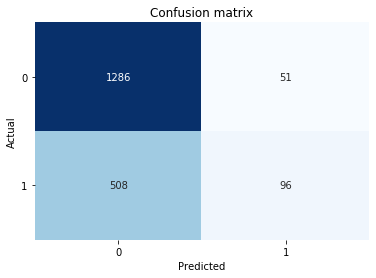

========= Eperiment -  df_A+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-209
df_A+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.79      0.29      0.42      1337
           1       0.35      0.83      0.49       604

    accuracy                           0.46      1941
   macro avg       0.57      0.56      0.46      1941
weighted avg       0.65      0.46      0.44      1941



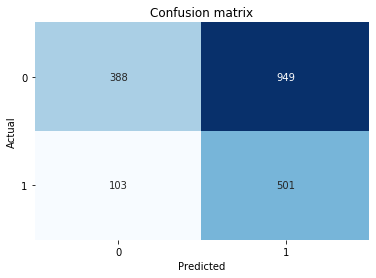

========= Eperiment -  df_A+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-210
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.712004,0.255659,0.15894,0.653061,0.560398
NB,0.458011,0.487829,0.82947,0.345517,0.559836


df_A+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1337
           1       0.69      0.20      0.30       604

    accuracy                           0.72      1941
   macro avg       0.71      0.58      0.57      1941
weighted avg       0.72      0.72      0.66      1941



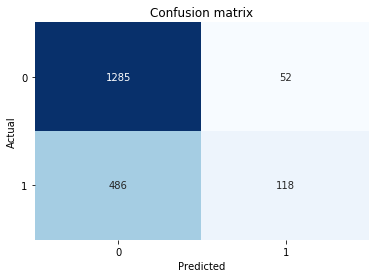

========= Eperiment -  df_A+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-211
df_A+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.78      0.37      0.50      1337
           1       0.36      0.77      0.49       604

    accuracy                           0.49      1941
   macro avg       0.57      0.57      0.49      1941
weighted avg       0.65      0.49      0.50      1941



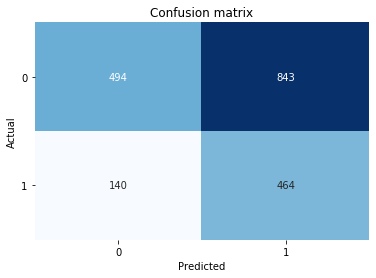

========= Eperiment -  df_A+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-212
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.722823,0.30491,0.195364,0.694118,0.578236
NB,0.493560,0.48561,0.768212,0.355011,0.568848


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF+W2V skipgram,0.712004,0.255659,0.158940,0.653061,0.560398
NB+W2V skipgram,0.458011,0.487829,0.829470,0.345517,0.559836
RF+W2V CBOW,0.722823,0.304910,0.195364,0.694118,0.578236
NB+W2V CBOW,0.493560,0.485610,0.768212,0.355011,0.568848


df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
df_B+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       867
           1       0.75      0.74      0.75      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.72      0.72      1904
weighted avg       0.72      0.72      0.72      1904



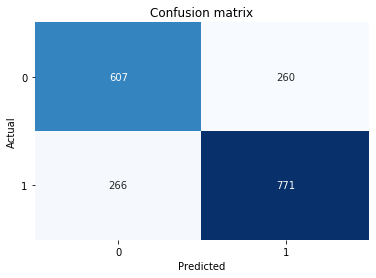

========= Eperiment -  df_B+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-213
df_B+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       867
           1       0.61      0.83      0.70      1037

    accuracy                           0.62      1904
   macro avg       0.62      0.60      0.58      1904
weighted avg       0.62      0.62      0.59      1904



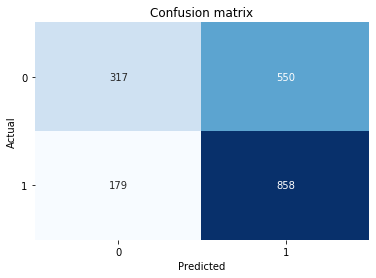

========= Eperiment -  df_B+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-214


Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 1344, in getresponse
    response.begin()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 267, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Kavishka\anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into

 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.723739,0.745648,0.743491,0.747818,0.721803
NB,0.617122,0.701840,0.827387,0.609375,0.596508


df_B+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       867
           1       0.75      0.76      0.76      1037

    accuracy                           0.73      1904
   macro avg       0.73      0.73      0.73      1904
weighted avg       0.73      0.73      0.73      1904



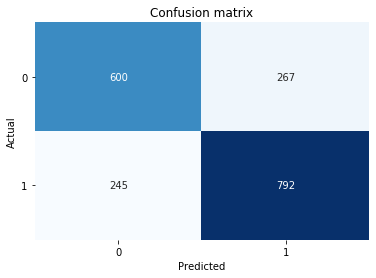

========= Eperiment -  df_B+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-215
df_B+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.65      0.42      0.51       867
           1       0.63      0.81      0.71      1037

    accuracy                           0.63      1904
   macro avg       0.64      0.62      0.61      1904
weighted avg       0.64      0.63      0.62      1904



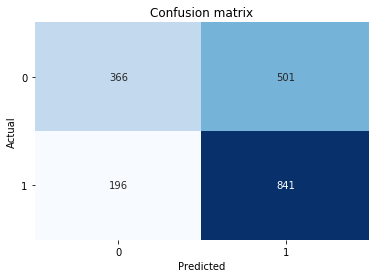

========= Eperiment -  df_B+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-216
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.731092,0.755725,0.763742,0.747875,0.727892
NB,0.633929,0.707020,0.810993,0.626677,0.616569


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF+W2V skipgram,0.723739,0.745648,0.743491,0.747818,0.721803
NB+W2V skipgram,0.617122,0.701840,0.827387,0.609375,0.596508
RF+W2V CBOW,0.731092,0.755725,0.763742,0.747875,0.727892
NB+W2V CBOW,0.633929,0.707020,0.810993,0.626677,0.616569


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+RF,0.712004,0.255659,0.158940,0.653061,0.560398
df_A+W2V skipgram+NB,0.458011,0.487829,0.829470,0.345517,0.559836
df_A+W2V CBOW+RF,0.722823,0.304910,0.195364,0.694118,0.578236
df_A+W2V CBOW+NB,0.493560,0.485610,0.768212,0.355011,0.568848
df_B+W2V skipgram+RF,0.723739,0.745648,0.743491,0.747818,0.721803
df_B+W2V skipgram+NB,0.617122,0.701840,0.827387,0.609375,0.596508
df_B+W2V CBOW+RF,0.731092,0.755725,0.763742,0.747875,0.727892
df_B+W2V CBOW+NB,0.633929,0.707020,0.810993,0.626677,0.616569


In [80]:
classifier_feature({'df_A':df_A,'df_B':df_B}, {'RF':RF,'NB':NB}, {'W2V skipgram':word2vec_skipgram_embedding,'W2V CBOW':word2vec_cbow_embedding})

## Visualization of tsne

In [71]:
def tsne_plot(model):
    from sklearn.manifold import TSNE
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.index_to_key:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   

In [ ]:
tsne_plot(model_cbow.wv)

## fine tuned pretrained one

In [ ]:
new_model.build_vocab(df_A.comment.values, update = True)
new_model.train(df_A.comment.values, total_examples=2, epochs = 1)
new_model.wv.vocab

## How stemming affect the word embedding

In [82]:
print(model.wv.most_similar('සිසුන'))
print(model.wv.most_similar('සිස'))
print(model.wv.most_similar('සිසුන'))
print(model.wv.most_similar('නොමැ'))  # නොමැති
print(model.wv.most_similar('නොමැති'))



[('්පොරෝජනයට', 0.7376485466957092), ('ක්\u200dරියාපිළිවෙතකි', 0.7028831243515015), ('\u200dසරසවි', 0.7002137899398804), ('බයින්ගෙන්', 0.6858236193656921), ('අටසහසකට', 0.658367395401001), ('වෘත්තීයවේදිනියන්', 0.6538061499595642), ('සිසුවියන්ය', 0.6532202959060669), ('සුසුවියන්', 0.6531831622123718), ('හැදැරූවන්ද', 0.6509316563606262), ('ශාස්ත\u200d්\u200dරපීඨ', 0.6508955359458923)]
[('ඊට්ටිකුල', 0.5869222283363342), ('විශේෂඥයාවරයාගේ', 0.5849105715751648), ('බෙකර්ලි', 0.574848473072052), ('ගුරුවරියෙක්මි', 0.5744667649269104), ('සටනේ\tකොළඹ', 0.5734717845916748), ('සිසසුන්ගෙ', 0.570600688457489), ('ජීක්ල්', 0.5696278214454651), ('ඒ.එෆ්', 0.5689621567726135), ('ඉංජිනේරුවිද්\u200dයා', 0.5683059096336365), ('ලැට්ටෝවෛද්\u200dය', 0.5654928684234619)]
[('්පොරෝජනයට', 0.7376485466957092), ('ක්\u200dරියාපිළිවෙතකි', 0.7028831243515015), ('\u200dසරසවි', 0.7002137899398804), ('බයින්ගෙන්', 0.6858236193656921), ('අටසහසකට', 0.658367395401001), ('වෘත්තීයවේදිනියන්', 0.6538061499595642), ('සිසුවියන්ය', 0.

## Visualize word embedding 